In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt

In [2]:
def display_images(input_image, enhanced_image, input_text="Input Image", output_text="Enhanced Image"):
    plt.figure(figsize=(12, 6))
    
    # Display Input Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title(input_text)
    plt.axis('off')
    
    # Display Enhanced Image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
    plt.title(output_text)
    plt.axis('off')
    
    # Show the images
    plt.show()

In [3]:
def filtering_based_enhancement(image,kernel_size):
    if kernel_size % 2 == 0:
        kernel_size += 1  # Make kernel size odd if it's even
    
    # Apply Median Filter
    enhanced_image = cv2.medianBlur(image, kernel_size)
    
    return enhanced_image

- A kernel (also called a filter or mask) is a small matrix used to process images. It slides over the image pixel by pixel and applies a mathematical operation to change the image in some way.

- What Does It Do? median blur
- It replaces each pixel with the median value from its neighboring pixels.

Instead of averaging, it picks the middle value, which helps preserve edges.

In [4]:
def compute_image_metrics(original, enhanced):
    """
    Computes PSNR, MSE, and SSIM between the original and enhanced images, 
    and prints the method names with corresponding values.
    
    Args:
    original (ndarray): The original image (BGR format).
    enhanced (ndarray): The enhanced image (BGR format).
    """
    # Calculate PSNR (Peak Signal-to-Noise Ratio)
    mse_val = np.mean((original - enhanced) ** 2)
    if mse_val == 0:
        psnr_value = 100  # Perfect match (no error)
    else:
        max_pixel = 255.0  # Max pixel value for an 8-bit image
        psnr_value = 20 * log10(max_pixel / sqrt(mse_val))
    
    # Calculate MSE (Mean Squared Error)
    mse_value = np.mean((original - enhanced) ** 2)

    # Calculate SSIM (Structural Similarity Index)
    ssim_value = ssim(original, enhanced, multichannel=True)
    return psnr_value, mse_value, ssim_value


- What is SSIM (Structural Similarity Index)?
- The Structural Similarity Index (SSIM) is a popular metric used to measure the similarity between two images. It focuses not just on pixel differences (like MSE or PSNR), but on how structurally similar two images are in terms of brightness, contrast, and structure.



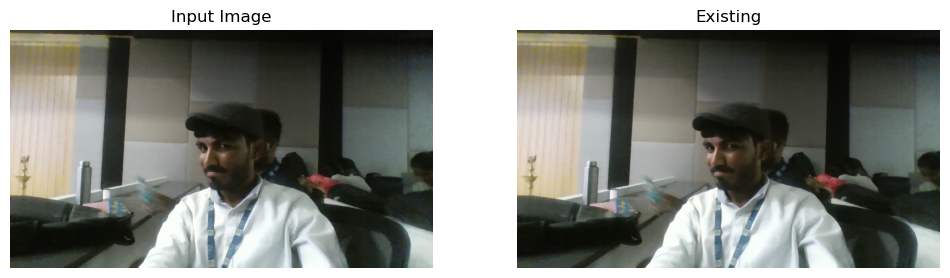

In [5]:
img_path = r"C:\Users\harsha reddy mallela\Pictures\Camera Roll\WIN_20250715_13_43_18_Pro.jpg"
img = cv2.imread(img_path)
filtered_img = filtering_based_enhancement(img, 3)
display_images(img, filtered_img, input_text="Input Image", output_text="Existing")
reduced_img=img

- PSNR (Peak Signal-to-Noise Ratio) in Simple Terms:
- Definition: A metric that tells how close the enhanced image is to the original.

#### Measured in: Decibels (dB)

- PSNR Value (dB)	Image Quality
- 10–20	Poor (high noise)
- 20–30	Acceptable
- 30–40	Good
- 40+	Excellent


In [6]:
psnr_value,mse_value,ssim_value = compute_image_metrics(img, filtered_img)
# Print Method Names and Corresponding Values

input_text="Existing Method"
print(f"{input_text}: PSNR, Value: {psnr_value:.2f} dB")
print(f"{input_text}: MSE, Value: {mse_value:.2f}")
print(f"{input_text}: SSIM, Value: {ssim_value:.4f}")

Existing Method: PSNR, Value: 44.45 dB
Existing Method: MSE, Value: 2.34
Existing Method: SSIM, Value: 0.9827


In [7]:
# Loop through different limits for analysis
limits = range(1, 13)  # Limits from 1 to 12
psnr_values, mse_values, ssim_values = [], [], []

for limit in limits:
    filtered_img = filtering_based_enhancement(reduced_img, limit)
    
    # Compute image metrics
    psnr_val, mse_val, ssim_val = compute_image_metrics(reduced_img, filtered_img)
    
    # Store values
    psnr_values.append(psnr_val)
    mse_values.append(mse_val)
    ssim_values.append(ssim_val)

# Each value in limits is passed into the image enhancement function to test how different kernel sizes affect the image filtering results.

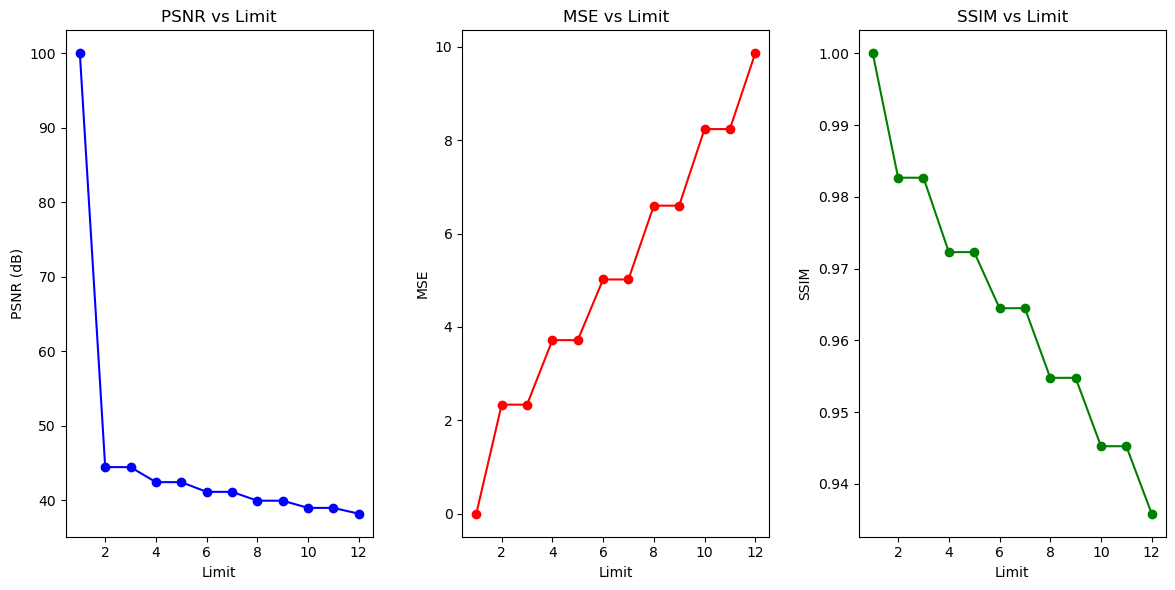

In [8]:
# Plot PSNR, MSE, SSIM vs Limit
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(limits, psnr_values, marker='o', color='b')
plt.title("PSNR vs Limit")
plt.xlabel("Limit")
plt.ylabel("PSNR (dB)")

plt.subplot(1, 3, 2)
plt.plot(limits, mse_values, marker='o', color='r')
plt.title("MSE vs Limit")
plt.xlabel("Limit")
plt.ylabel("MSE")

plt.subplot(1, 3, 3)
plt.plot(limits, ssim_values, marker='o', color='g')
plt.title("SSIM vs Limit")
plt.xlabel("Limit")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()


In [9]:
def hybrid_adaptive_hist_eq(image, block_size,limit):
    # Convert to YCrCb color space
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_ycrcb)
    
    # Calculate local contrast (variance) in the Y channel to dynamically adjust the clipLimit
    height, width = y.shape
    local_contrast = np.zeros_like(y)
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            # Get the block of the image
            block = y[i:i+block_size, j:j+block_size]
            
            # Calculate the variance of the block (local contrast)
            local_contrast[i:i+block_size, j:j+block_size] = np.var(block)
    
    # Normalize the local contrast to use as a basis for the clipLimit
    max_contrast = np.max(local_contrast)
    min_contrast = np.min(local_contrast)
    contrast_range = max_contrast - min_contrast
    
    # Dynamic adjustment of the clipLimit based on local contrast (dynamic histogram control)
    adaptive_clip_limit = limit * (contrast_range / (max_contrast + 1e-5))  # Avoid division by zero
    adaptive_clip_limit= min(adaptive_clip_limit,limit)
    # Apply CLAHE with the dynamically adjusted clipLimit
    clahe = cv2.createCLAHE(clipLimit=adaptive_clip_limit, tileGridSize=(8, 8))
    cl = clahe.apply(y)
    
    # Merge back the Y, Cr, Cb channels
    img_ycrcb = cv2.merge([cl, cr, cb])
    
    # Convert back to BGR
    result = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2BGR)
    return result

#### YCrCb
- Formats like JPEG, MPEG use YCrCb because they can compress color channels more than brightness without much visual loss.

#### This function:

- Improves image brightness and contrast locally.

- Adapts the enhancement strength based on local contrast.

- Uses CLAHE, but with a smart, dynamically scaled clipLimit for better control.

- Maintains natural colors by working only on the brightness channel.

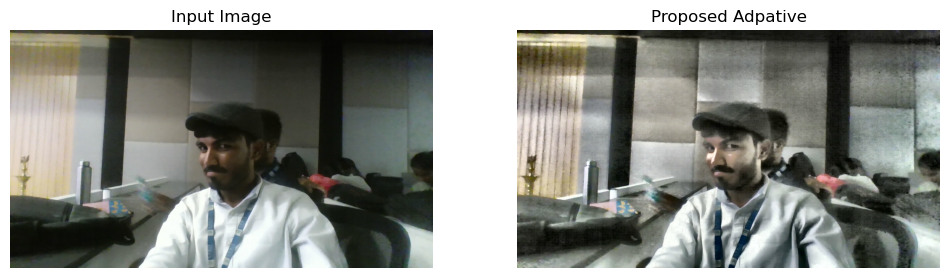

In [10]:
limit=6
enhanced_image = hybrid_adaptive_hist_eq(reduced_img, 16, limit)  # Apply adaptive histogram equalization
display_images(reduced_img, enhanced_image, input_text="Input Image", output_text="Proposed Adpative")


In [11]:
reduced_img1 = reduced_img.astype(np.float32) / 255.0
enhanced_image1 = enhanced_image.astype(np.float32) / 255.0
psnr_value,mse_value,ssim_value = compute_image_metrics(reduced_img1, enhanced_image1)
input_text="Proposed Method"
print(f"{input_text}: PSNR, Value: {psnr_value:.2f} dB")
print(f"{input_text}: MSE, Value: {mse_value:.2f}")
print(f"{input_text}: SSIM, Value: {ssim_value:.4f}")

Proposed Method: PSNR, Value: 62.47 dB
Proposed Method: MSE, Value: 0.04
Proposed Method: SSIM, Value: 0.7648


In [ ]:
# Loop through different limits for analysis
limits = range(1, 13)  # Limits from 1 to 12
psnr_values, mse_values, ssim_values = [], [], []

for limit in limits:
    # Apply hybrid adaptive histogram equalization
    enhanced_image = hybrid_adaptive_hist_eq(reduced_img, block_size=16, limit=limit)
    
    # Normalize to [0, 1] for metrics computation
    reduced_img1 = img.astype(np.float32) / 255.0
    enhanced_image1 = enhanced_image.astype(np.float32) / 255.0
    
    # Compute image metrics
    psnr_val, mse_val, ssim_val = compute_image_metrics(reduced_img1, enhanced_image1)
    
    # Store values
    psnr_values.append(psnr_val)
    mse_values.append(mse_val)
    ssim_values.append(ssim_val)


In [ ]:
# Plot PSNR, MSE, SSIM vs Limit
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(limits, psnr_values, marker='o', color='b')
plt.title("PSNR vs Limit")
plt.xlabel("Limit")
plt.ylabel("PSNR (dB)")

plt.subplot(1, 3, 2)
plt.plot(limits, mse_values, marker='o', color='r')
plt.title("MSE vs Limit")
plt.xlabel("Limit")
plt.ylabel("MSE")

plt.subplot(1, 3, 3)
plt.plot(limits, ssim_values, marker='o', color='g')
plt.title("SSIM vs Limit")
plt.xlabel("Limit")
plt.ylabel("SSIM")

plt.tight_layout()
plt.show()


In [ ]:
# Display enhanced images with subplots (max 3 rows and 4 columns)
num_images = len(limits)
rows = 3
cols = 4
plt.figure(figsize=(15, 12))

for i, limit in enumerate(limits):
    plt.subplot(rows, cols, i+1)
    enhanced_image = hybrid_adaptive_hist_eq(img, block_size=16, limit=limit)
    plt.imshow(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Limit {limit}")
    plt.axis('off')

plt.tight_layout()
plt.show()

How CLAHE Works:
Divide the image into small blocks (tiles), e.g., 8×8 or 16×16.

Apply histogram equalization to each block separately.

Limit contrast enhancement in each block using clipLimit to avoid noise.

Smooth the borders between blocks by interpolating them.